**Import and call functions**

In [6]:
#Import and functions
try: import pandas as pd
except ImportError:
    import subprocess
    subprocess.check_call(['pip','install','pandas'])
    import pandas as pd

pd.set_option('future.no_silent_downcasting',True)



try: import numpy as np 
except ImportError:
    import subprocess
    subprocess.check_call(['pip','install','numpy'])
    import numpy as np

try: import glob
except ImportError:
    import subprocess
    subprocess.check_call(['pip','install','glob'])
    import glob


import os
import re
import warnings
from datetime import datetime, timedelta
from openpyxl import load_workbook
from sas7bdat import SAS7BDAT #not very useful as takes over 3hours just to read the MyCustomer Database


#Adding Variables to limit data
Current_date = datetime.now().date()
QA_Start_date = datetime(Current_date.year,Current_date.month-1,1).date()
QA_Stop_Date = datetime(Current_date.year,Current_date.month,1).date()-timedelta(days=1)
ResDateStart = datetime(Current_date.year,Current_date.month,1).date()
ResDateStop = datetime(Current_date.year,Current_date.month+1,1).date()-timedelta(days=1)
GDPR_Date = Current_date-timedelta(days=365)
Replace_dictionary = {'_x0020_':' ','_x0028_':'(','_x0029_':')','_x0026_':'&'}

def Clean_location(row):
    Location = row['LOCATION']
    if Location =='Pudsey':
        return 'Leeds'
    elif Location == 'Leeds Headrow':
        return 'Leeds'
    elif Location=='Birm Liv St':
        return 'Birmingham'
    else:
        return Location.capitalize()


def Anonymize_data(row,GDPR_Date):
    Anon_date = row['Response_date']
    if Anon_date.date() < GDPR_Date:
        return 0
    else:
        return row['Customer_Age']

def Import_and_Merge(input_folder,file_extension="csv"):
    all_files = glob.glob(os.path.join(input_folder,f'*.{file_extension}'))

    dfs = []

    for file_path in all_files:
        if os.path.isfile(file_path):  # Check if it's a file
            try:

                # Read the file into a DataFrame
                df = pd.read_csv(file_path,encoding='utf-8')  # Change this to pd.read_excel(file_path) for Excel files
                dfs.append(df)
            except pd.errors.ParserError as e:
                print(f"Error reading file {file_path}: {e}")

    # Concatenate all dataframes into one
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df
    

**Dates and events**

In [2]:
#list of Dates and events
Surge_events = [{'Surge_start':'2018-02-24','Surge_stop':'2018-03-04'}#Beast from the east
,{'Surge_start':'2020-02-09','Surge_stop':'2020-02-11'} #Storm Ciara
,{'Surge_start':'2020-02-15','Surge_stop':'2020-02-21'} #Storm Dennis
,{'Surge_start':'2020-03-01','Surge_stop':'2021-12-08'} #Covid19
]

#Covid flags
Covid_Keywords = ['Covid','Coronavirus','virus','Lockdown','corona','lock down','pandemic','epidemic','unprecedented','isolation',
'crisis','social distancing','NHS','Key Worker','Covid-19','Covid19','Covid9','masks','face masks','face coverings','Tier','Test and trace',
'test & trace','T & T','T and T','T N T','track and trace','Plague','Mental','Financial','health','PPE','Vaccine','Pfizer','Astra Zenica',
'Jab','innoculation','Moderna','Variant','Delta','Delta Variant','Omicron','Omicron Variant']


#Cost of Living flags


Covid_start_date = '2020-03-01'
Covid_end_date = '2021-12-08'

**Import old data and new data**

In [8]:
Year = datetime.today().year
#Old MyCustomer Data
with open('\\\\RLBYCCMPFS06\\SWAP\\Claims Customer Experience Team\\02 Claims Customer Data\\07 MyCustomer\\MyCustomer_Database_V4.csv','r',encoding = 'latin-1') as file_name:
    MyC_Old_Data = pd.read_csv(file_name,encoding='unicode_escape')

#new MyCustomer Data
input_folder = f'\\\\rlbyccmpfs06\\public\\Private Cust Data\\Incoming_Data\\KPMG\\DashBoardData\\Archive\\Claims Archive\\{Year}\\'

combined_df = Import_and_Merge(input_folder)
combined_df.drop_duplicates(keep='last',inplace=True)

combined_df['Response Date'] = pd.to_datetime(combined_df['Response Date'],errors='coerce')
combined_df['Response Date'] = combined_df['Response Date'].dt.strftime('%d/%m/%Y')
combined_df['Transaction Date'] = pd.to_datetime(combined_df['Transaction Date'],errors='coerce')
combined_df['Transaction Date'] = combined_df['Transaction Date'].dt.strftime('%d/%m/%Y')

max_resDate=combined_df['Response Date'].max()
print(max_resDate)

New_Cols_to_Keep = ['Touchpoint','Message','Transaction Date','Channel','Director','Senior Manager','Manager','Transaction Type','Brand',
'Product','Customer Tenure', 'Customer Age', 'Note Type','Claim no.','Claim ID','Policy Number', 'Date of Registration','Days since Registration','Loss Type', 
'ConExp','NPS','Ease','Cat 1',
'Exceptions', 'Consultant ID','Suggested Survey', 'Suggested Survey 2', 'Journey Selected','Journey Satisfaction','Journey Message', 
'Source System','Status','Claims Advisor Name','Team Leader','ConversationId','Response Date']

Old_Cols_to_Keep = ['Touchpoint','Message','Transaction_Date','Channel','Director','Senior_manager','Manager','Transaction_type',
'Brand','Product','Customer_tenure', 'Customer_Age', 'Note_type','Claim_no_','Claim_ID',
'Policy_Number', 'Date_of_registration','No__of_days_since_registration','Peril', 'ConExp','NPS','Ease','Cat_1',
'Exceptions', 'RACF','SuggestedSurvey', 'SuggestedSurvey2', 'Selected_Journey','Journey_Satisfaction','Journey_Verbatim','Source_System',
'Status','Claims_Advisor_Name','Team_Leader','ConversationId','Response_date']

MYC_New = combined_df[New_Cols_to_Keep]
MyC_Old = MyC_Old_Data[Old_Cols_to_Keep]


C:\Users\HUCC\AppData\Local\Temp\ipykernel_17792\2170988717.py:4: DtypeWarning: Columns (1,2,7,18,23,25,26,32,34,42,46,47,48,50,53) have mixed types. Specify dtype option on import or set low_memory=False.
  MyC_Old_Data = pd.read_csv(file_name,encoding='unicode_escape')


Error reading file \\rlbyccmpfs06\public\Private Cust Data\Incoming_Data\KPMG\DashBoardData\Archive\Claims Archive\2024\Claims_MyCustomer_2024_May.csv: Error tokenizing data. C error: Expected 45 fields in line 547749, saw 84



C:\Users\HUCC\AppData\Local\Temp\ipykernel_17792\3082295893.py:71: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,encoding='utf-8')  # Change this to pd.read_excel(file_path) for Excel files


31/12/2023


**Combined the new files together**

In [9]:
def align_column_names(df, column_mapping):
    return df.rename(columns =column_mapping)

column_mapping = {'Transaction Date':'Transaction_Date','Transaction Type':'Transaction_type','Customer Tenure':'Customer_tenure','Customer Age':'Customer_Age','Note Type':'Note_type','Claim no.':'Claim_no_','Claim ID':'Claim_ID','Policy Number':'Policy_Number','Date of Registration':'Date_of_registration',
'Days since Registration':'No__of_days_since_registration','Loss Type':'Peril','Cat 1':'Cat_1','Consultant ID':'RACF','Suggested Survey':'SuggestedSurvey','Suggested Survey 2':'SuggestedSurvey2','Journey Selected':'Selected_Journey','Journey Satisfaction':'Journey_Satisfaction','Journey Message':'Journey_Verbatim',
'Source System':'Source_System','Claims Advisor Name':'Claims_Advisor_Name','Team Leader':'Team_Leader','Response Date':'Response_date'}

MYC_New = align_column_names(MYC_New,column_mapping)

if MyC_Old.columns.duplicated().any():
    print("Duplicate columns found in MyC_Old:", MyC_Old.columns[MyC_Old.columns.duplicated()])

columns_to_check = ['Claim_no_','Transaction_Date','RACF','Response_date','Transaction_type']
MyC_Complete = pd.concat([MyC_Old,MYC_New],ignore_index=True).drop_duplicates(subset=columns_to_check)
MyC_Complete['Response_date']=pd.to_datetime(MyC_Complete['Response_date'],format='%d/%m/%Y')
#1731659 all fields
#1718112 ['Claim_no_','Transaction_Date','RACF','Response_date','Transaction_type'] <---- using this one as most balanced
#1666707 ['Claim_no_','Transaction_Date']

MYC_complete_Max = pd.to_datetime(MyC_Complete['Response_date'],format='%d/%m/%Y').max()
print(MYC_complete_Max.strftime('%d/%m/%Y'))


05/06/2024


**Brand Change of Motability**

In [10]:
MyC_Complete.loc[MyC_Complete['Product']=='Motability','Brand']="Direct Line Motability"

**Addition of FL data**

In [11]:
Frontline = pd.read_csv('\\\\rlbyccmpfs06\\swap\\Claims Customer Experience Team\\02 Claims Customer Data\\07 MyCustomer\\SAS CSV inputs\\FL_HIERARCHY.csv')
Departments = pd.read_excel('\\\\rlbyccmpfs06\\swap\\Claims Customer Experience Team\\02 Claims Customer Data\\07 MyCustomer\\SAS CSV inputs\\Department_Fix.xls')

LB = pd.to_datetime('2000-01-01 00:00:00')
UB = pd.to_datetime('2100-12-31 23:59:59')

def parse_dates(date):
    for fmt in ('%d/%m/%Y', '%d%b%Y', '%d%b%y', '%Y-%m-%d'):
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            pass
    # Handle dates far in the future
    try:
        if int(date[-4:]) > 2100:
            return UB
    except (ValueError, TypeError):
        pass
    raise ValueError(f"No valid date format found for {date}")

FrontlineNew = Frontline.copy()

FrontlineNew['EFF_START_DATE'] = Frontline['EFF_START_DATE'].apply(parse_dates).dt.strftime('%d/%m/%Y')
FrontlineNew['EFF_END_DATE'] = Frontline['EFF_END_DATE'].apply(parse_dates).apply(lambda x:UB if x > UB else x).dt.strftime('%d/%m/%Y')
FrontlineNew['LOCATION'] = Frontline['LOCATION'].replace(Replace_dictionary, regex=True)

#remove NaN values
Frontline['FL_Name']= Frontline['FL_Name'].fillna('')
#Split the FL Name into FN and LN and recombine to CA Name
FrontlineNew['Claims_Advisor_Name'] = Frontline['FL_Name'].apply(lambda x: ' '.join(x.split(', ')[::-1]))
FrontlineNew['Claims_Advisor_Name'] = FrontlineNew['Claims_Advisor_Name'].replace(Replace_dictionary,regex=True)
FrontlineNew['DEPARTMENT'] = Frontline['DEPARTMENT'].replace(Replace_dictionary,regex=True)



**Merge MyCustomer With Frontline**

In [12]:

chunk_size = 50000  # Adjust chunk size based on your system's memory capacity

chunks = []
for start in range(0, len(MyC_Complete), chunk_size):
    MyC_chunk = MyC_Complete.iloc[start:start + chunk_size]
    merged_chunk = pd.merge(MyC_chunk, FrontlineNew[['RACF', 'LOCATION', 'DEPARTMENT', 'EFF_START_DATE', 'EFF_END_DATE', 'Current_Record', 'Claims_Advisor_Name', 'USER_ACTIVE_FLG']],
                            how='left', on='RACF', suffixes=('_MyC', '_FL'))
    
    # Convert the 'Transaction_Date' column to datetime without specifying format
    merged_chunk['Transaction_Date'] = pd.to_datetime(merged_chunk['Transaction_Date'], dayfirst=True, errors='coerce')
    # Convert 'EFF_START_DATE' and 'EFF_END_DATE' to datetime without specifying format
    merged_chunk['EFF_START_DATE'] = pd.to_datetime(merged_chunk['EFF_START_DATE'], dayfirst=True, errors='coerce')
    merged_chunk['EFF_END_DATE'] = pd.to_datetime(merged_chunk['EFF_END_DATE'], dayfirst=True, errors='coerce')

    # Apply date filtering conditionally
    date_filtered_chunk = merged_chunk[
        (merged_chunk['Transaction_Date'] >= merged_chunk['EFF_START_DATE']) & 
        (merged_chunk['Transaction_Date'] <= merged_chunk['EFF_END_DATE'])
    ]

    # Handle rows where 'EFF_START_DATE' or 'EFF_END_DATE' are NaN (these rows are kept)
    no_date_filtered_chunk = merged_chunk[
        merged_chunk['EFF_START_DATE'].isna() | merged_chunk['EFF_END_DATE'].isna()
    ]

    # Combine the filtered and unfiltered chunks
    combined_filtered_chunk = pd.concat([date_filtered_chunk, no_date_filtered_chunk]).drop_duplicates(keep='last')

    chunks.append(combined_filtered_chunk)

# Concatenate all chunks
MyCustomer_merge = pd.concat(chunks, ignore_index=True)

# Mark the current record
MyCustomer_merge['Current_Record'] = MyCustomer_merge['Current_Record'].apply(lambda x: 'N' if x != 'Y' else x)



**Department mapping**

In [13]:
Department_Export = pd.DataFrame({'DEPARTMENT': MyCustomer_merge['DEPARTMENT'].unique()})
#Department_Export['DEPARTMENT'] = Department_Export['DEPARTMENT'].replace(Replace_dictionary,regex=True)

Excelfile = '\\\\rlbyccmpfs06\\swap\\Claims Customer Experience Team\\02 Claims Customer Data\\07 MyCustomer\\SAS CSV inputs\\Department_Fix_Python.xlsx' 

DWB = load_workbook(Excelfile,data_only=True)

Export_sheet = DWB['Python Export']    

for row in Export_sheet.iter_rows(min_row=2,max_row = Export_sheet.max_row,min_col=1,max_col=Export_sheet.max_column):
    for cell in row:
        cell.value = None

for index, row in enumerate(Department_Export.iterrows(),start=2):
    for col_index, value in enumerate(row[1]):
        Export_sheet.cell(row=index,column=col_index+1,value=value)

DWB.save(Excelfile)

#Import the fixed data from excel back for matching

sheet_imports = DWB['Import to Python']

rows = []

for row in sheet_imports.iter_rows(values_only=True):
    rows.append(row)


Mapped_Departments = pd.DataFrame(rows[1:],columns=rows[0])

Mapped_Departments['Old Department '] = Mapped_Departments['Old Department '].fillna('')

**Add to main dataframe**

In [14]:
#Add new departments to MyCustomer Merge
MyCustomer_DepFix = pd.merge(MyCustomer_merge,Mapped_Departments, how='left', left_on='DEPARTMENT',right_on='Old Department ') 
MyCustomer_DepFix.drop(columns=['DEPARTMENT','Old Department '],inplace=True)
MyCustomer_DepFix.rename(columns={'Old Department ':'Department'}, inplace=True)
MyCustomer_Clean = MyCustomer_DepFix.fillna('')

#Adding in Offshore logic here
Offshore_Location = ['pune','noida','cape town']

MyCustomer_Clean['Offshore'] = MyCustomer_Clean.apply(
    lambda row: 1 if row['LOCATION'].lower() in Offshore_Location or 'offshore' in row['Senior_manager'].lower() else 0,
    axis=1
)
MyCustomer_Clean['Surge'] = 0 #initialize the field

for Surge_event in Surge_events:
    start_date = pd.to_datetime(Surge_event['Surge_start'])
    end_date = pd.to_datetime(Surge_event['Surge_stop'])

MyCustomer_Clean.loc[
    (pd.to_datetime(MyCustomer_Clean['Transaction_Date'])>= start_date) 
    &
     (pd.to_datetime(MyCustomer_Clean['Transaction_Date'])<= end_date),'Surge'] = 1

MyCustomer_Clean['LOCATION'] = MyCustomer_Clean.apply(Clean_location,axis=1)
MyCustomer_Clean['Response_date']=pd.to_datetime(MyCustomer_Clean['Response_date'],format = 'mixed')
MyCustomer_Clean['Customer_Age'] = MyCustomer_Clean.apply(lambda row: Anonymize_data(row,GDPR_Date),axis=1)

#Brand mapping
Brand_mapping = {"dir":"Direct Line",
                "Dir":"Direct Line",
                "Nation":"Nationwide Insurance",
                "nation":"Nationwide Insurance",
                "natw":"NatWest Insurance",
                "Natw":"NatWest Insurance",
                "NatW":"NatWest Insurance",
                "RBS":"RBS Insurance",
                "Prud":"Prudential Insurance",
                "prud":"Prudential Insurance",
                "Sains":"U K Insurance",
                "UK Insurance":"U K Insurance",
                "Cit":"Citroen Insurance",
                "cit":"Citroen Insurance",
                "Peu":"Peugeot Insurance",
                "VW":"VW Group",
                "Volk":"VW Group",
                "Sko":"SKODA",
                "SKO":"SKODA",
                "Mota":"Direct Line Motability"}

for key, value in Brand_mapping.items():
    MyCustomer_Clean.loc[MyCustomer_Clean['Brand'].str.contains(key,case=False),'Brand'] = value

MyCustomer_Clean['Transaction_Date'] = pd.to_datetime(MyCustomer_Clean['Transaction_Date'])
MyCustomer_Clean['ConExp'] = pd.to_numeric(MyCustomer_Clean['ConExp'],errors='coerce')
MyCustomer_Clean['ConExp'] = MyCustomer_Clean['ConExp'].astype('Int64')

MyCustomer_Clean.loc[(MyCustomer_Clean['Transaction_Date']<'2022-04-06')&(MyCustomer_Clean['Status']=="")&(MyCustomer_Clean['ConExp']> 4),'Status'] = "Not an alert generating transaction"
MyCustomer_Clean.loc[(MyCustomer_Clean['Transaction_Date']<'2022-04-06')&(MyCustomer_Clean['ConExp']> 4),'Status'] = "Not an alert generating transaction"

MyCustomer_Clean.loc[(MyCustomer_Clean['Transaction_Date']>='2022-04-06')&(MyCustomer_Clean['Status']=="")&(MyCustomer_Clean['ConExp']> 6),'Status'] = "Not an alert generating transaction"
MyCustomer_Clean.loc[(MyCustomer_Clean['Transaction_Date']>='2022-04-06')&(MyCustomer_Clean['ConExp']> 6),'Status'] = "Not an alert generating transaction"
MyCustomer_Clean.loc[(MyCustomer_Clean['Transaction_Date']>='2022-04-06')&(MyCustomer_Clean['Status']=="")&(MyCustomer_Clean['ConExp']<= 6),'Status'] = "Open"

MyCustomer_Clean.loc[(MyCustomer_Clean['New Department']=="")&(MyCustomer_Clean['Product']=="Travel"),'New Department'] = "Travel Resolution"

MyCustomer_Clean.rename(columns={'MyCustomer2_ref':'ConversationId','New Department':'Department','Journey_Sat':'Journey_Satisfaction',
'Claims_Advisor_Name_MyC':'Claims_Advisor_Name','No__of_days_since_registration':'Days_since_registration','LOCATION':'Location'},inplace=True)


MyCustomer_Clean['Date'] = (MyCustomer_Clean['Transaction_Date'] - pd.offsets.MonthBegin(1)).dt.strftime('%d/%m/%Y')
MyCustomer_Clean['Quarter'] = pd.PeriodIndex(MyCustomer_Clean['Transaction_Date'],freq='Q').strftime('Q%q')
MyCustomer_Clean['Next']=""

max_Rdate = MyCustomer_Clean['Response_date'].max()
print('Max response date before:',max_Rdate.strftime('%d/%m/%Y'))

MyCustomer_Clean['Response_date'] = pd.to_datetime(MyCustomer_Clean['Response_date'],format='%m/%d/%Y')
max_Rdate2 = MyCustomer_Clean['Response_date'].max()
print('Max response date 2 before:',max_Rdate.strftime('%d/%m/%Y'))

MyCustomer_Clean['Response_date'] = MyCustomer_Clean['Response_date'].dt.strftime('%d/%m/%Y')

max_Rdate3 = MyCustomer_Clean['Response_date'].max()
print('Max response date after:',max_Rdate3)

Max response date before: 05/06/2024
Max response date 2 before: 05/06/2024
Max response date after: 31/12/2023


**MyCustomer export structure**

In [15]:
MyCustomer_Final = MyCustomer_Clean.loc[:,[
'Touchpoint',
'ConversationId',
'Message',
'Response_date',
'Transaction_Date',
'Channel',
'Director',
'Senior_manager',
'Manager',
'Team_Leader',
'Claims_Advisor_Name',   
'Transaction_type',
'Brand',
'Product',
'Customer_tenure',
'Customer_Age',
'Note_type',
'Claim_no_' ,
'Claim_ID',
'Policy_Number',
'Date_of_registration',
'Days_since_registration',
'ConExp',
'NPS',
'Ease',
'Next',
'Cat_1',
'Status',
'Department',
'Location',
'Date',
'Offshore',
'Surge',
'Exceptions',
'Peril',
'RACF',
'SuggestedSurvey',
'SuggestedSurvey2',
'Selected_Journey',
'Journey_Satisfaction',
'Journey_Verbatim',
'Source_System',
'Quarter'
]]

max_date = pd.to_datetime(MyCustomer_Final['Response_date'],format='%d/%m/%Y').max()
print(max_date.strftime('%d/%m/%Y'))

05/06/2024


**Export for Sam**

In [16]:
#sam export
#Columns_to_Drop = ['Touchpoint','ConversationId','Message','Sentiment','Response_date','Action_date','Mobile_number','Same_brand_product_holding','Surname','Title','Next','Cat_2','Notes','Covid19']
Current_Year = datetime.now().year
Previous_year = Current_Year-1

MyCustomer_For_Sam = MyCustomer_Final[MyCustomer_Final['Transaction_Date'].dt.year.isin([Current_Year,Previous_year])].sort_values(by='Transaction_Date').drop(columns=['Touchpoint'])

Export_Location = "\\\\rlbyccmpfs06\\swap\\Claims Customer Experience Team\\01 Claims Exec Packs\\Claims Exec Papers\\2024\\Data Sources\\"
FileName = f'MyCustomer_Raw_output_Reporting.csv'

MyCustomer_For_Sam.to_csv(Export_Location+FileName,index=False)

**Base file update for appending to**

In [19]:
Keep_Years = Current_Year-5

MyCustomer_For_Keeping = MyCustomer_Final[MyCustomer_Final['Transaction_Date'].dt.year.between(Keep_Years,Current_Year)].sort_values(by='Transaction_Date')
MyCustomer_For_Keeping['Transaction_Date'] = pd.to_datetime(MyCustomer_For_Keeping['Transaction_Date'],format = '%d/%m/%Y').dt.strftime('%d/%m/%Y')

Keep_location = "\\\\rlbyccmpfs06\\swap\\Claims Customer Experience Team\\02 Claims Customer Data\\07 MyCustomer\\Data\\"
keep_file = f'MyCustomer_Python_Extract_5Y.csv'

endtime = datetime.now()
print(f"file: {keep_file} complete at {endtime.strftime('%H:%M:%S')}")

MyCustomer_For_Keeping.to_csv(Keep_location+keep_file,index=False)
live_location = '\\\\RLBYCCMPFS06\\SWAP\\Claims Customer Experience Team\\02 Claims Customer Data\\07 MyCustomer\\'
live_file = 'MyCustomer_Database_V4.csv'

MyCustomer_For_Keeping.to_csv(live_location+live_file,index=False)
print(f"file: {live_file} complete")

endtime = datetime.now()
print(f"Process Completed at: {endtime.strftime('%H:%M:%S')}")

file: MyCustomer_Python_Extract_5Y.csv complete
file: MyCustomer_Database_V4.csv complete


**Volume Check**

       Date     Product  Volume
0   2024-01        Home    2553
1   2024-01  Motability    2248
2   2024-01       Motor    5739
3   2024-01      Travel    2557
4   2024-02        Home    1954
5   2024-02  Motability    1967
6   2024-02       Motor    5169
7   2024-02      Travel    2045
8   2024-03        Home    1840
9   2024-03  Motability    1267
10  2024-03       Motor    4958
11  2024-03      Travel    1811
12  2024-04        Home    1772
13  2024-04  Motability     993
14  2024-04       Motor    5141
15  2024-04      Travel    1930
16  2024-05        Home    1469
17  2024-05  Motability     791
18  2024-05       Motor    5207
19  2024-05      Travel    1444
20  2024-06        Home     126
21  2024-06  Motability      44
22  2024-06       Motor     356
23  2024-06      Travel      83


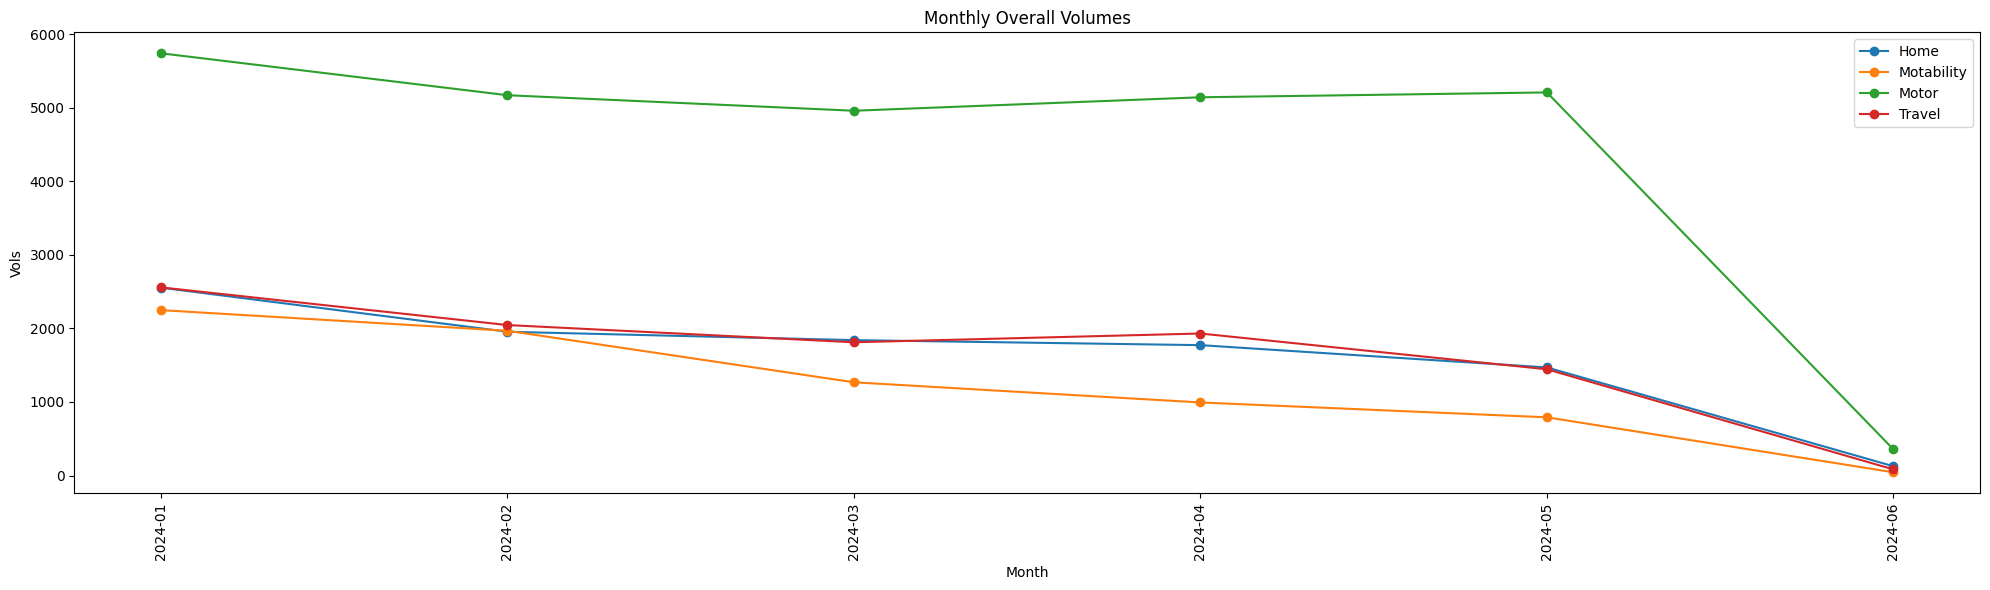

Process Completed at: 14:40:31


In [20]:
try: import matplotlib.pyplot as plt 
except ImportError:
    import subprocess
    subprocess.check_call(['pip','install','matplotlib'])
    import matplotlib.pyplot as plt


MyCustomer_Clean['Transaction_Date_2'] = pd.to_datetime(MyCustomer_Clean['Transaction_Date'],format = '%d/%m/%Y')
MyCustomer_Clean['Date']=MyCustomer_Clean['Transaction_Date_2'].dt.to_period('M')
MyCustomer_Clean['Transaction_Date_2'] = MyCustomer_Clean['Transaction_Date_2'].dt.strftime('%d/%m/%Y')


Volume_Check = MyCustomer_Clean[MyCustomer_Clean['Date'].dt.year==2024].groupby(['Date','Product']).size().reset_index(name='Volume')
#Volume_Check = MyCustomer_Clean.groupby(['Date','Product']).size().reset_index(name='Volume')

print(Volume_Check)
plt.figure(figsize=(20,6))

for Product,group in Volume_Check.groupby('Product'):
    plt.plot(group['Date'].astype(str),group['Volume'],marker = 'o', linestyle='-', label=Product)

#plt.plot(Volume_Check['Date'].astype(str),Volume_Check['Volume'],marker='o',linestyle='-')
plt.xlabel('Month')
plt.ylabel('Vols')
plt.title('Monthly Overall Volumes')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

endtime = datetime.now()
print(f"Process Completed at: {endtime.strftime('%H:%M:%S')}")